In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
# Import gensim packages
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy

In [3]:
#read data into pandas dataframes
train= pd.read_csv('Train.csv')
test= pd.read_csv('Test.csv')
mapping= pd.read_csv('Mapping.csv')

In [4]:
train.head()

,Unnamed: 0,TEXT,Label
0,0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,2,Been friends since 7th grade. Look at us now w...,2
3,3,This is what it looks like when someone loves ...,3
4,4,RT @user this white family was invited to a Bl...,3


In [5]:
#printing rows of the mapping dataset
mapping.head()

,Unnamed: 0,emoticons,number
0,0,😜,0
1,1,📸,1
2,2,😍,2
3,3,😂,3
4,4,😉,4


In [6]:
mapping.shape

(20, 3)

In [7]:
#create a dictionary of emoji and number
mapping.drop(axis=1, labels='Unnamed: 0')

,emoticons,number
0,😜,0
1,📸,1
2,😍,2
3,😂,3
4,😉,4
5,🎄,5
6,📷,6
7,🔥,7
8,😘,8
9,❤,9


In [8]:
#create list of emoticons to input into the hash table
emoticons= mapping['emoticons'].to_list()

In [9]:
#create hash map of emoticons
map={}
for emo in range(0, len(emoticons)):
  map[emo]= emoticons[emo]

print(map)

{0: '😜', 1: '📸', 2: '😍', 3: '😂', 4: '😉', 5: '🎄', 6: '📷', 7: '🔥', 8: '😘', 9: '❤', 10: '😁', 11: '🇺🇸', 12: '☀', 13: '✨', 14: '💙', 15: '💕', 16: '😎', 17: '😊', 18: '💜', 19: '💯'}


Text(0.5, 1.0, 'Plotting frequency of emojis used')

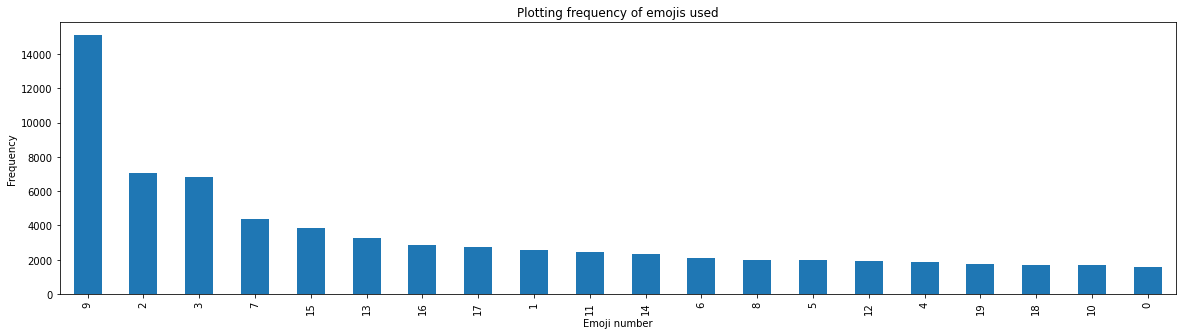

In [10]:
#plotting frequency of emoticons in descending order to give insight into the most frequently used emoticons
plt.rcParams["figure.figsize"] = (20,5)
train['Label'].value_counts().plot(kind='bar')
plt.xlabel('Emoji number')
plt.ylabel('Frequency')
plt.title('Plotting frequency of emojis used')

In [11]:
#drop unnrelated column
train.drop('Unnamed: 0',axis=1)

,TEXT,Label
0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,Been friends since 7th grade. Look at us now w...,2
3,This is what it looks like when someone loves ...,3
4,RT @user this white family was invited to a Bl...,3
...,...,...
69995,"Yes, I call Galina ""my Bubie"" Go follow my bea...",3
69996,"I SEA you, Seattle @ Ballard Seafood Festival\n",16
69997,If one of my daughters is wearing this and ask...,2
69998,Guess who whoop people on THEIR homecoming?! #...,3


In [12]:
#read test data
test.head()

,Unnamed: 0,id,TEXT
0,0,0,Thought this was cool...#Repost (get_repost)・・...
1,1,1,Happy 4th! Corte madera parade. #everytownusa ...
2,2,2,Luv. Or at least something close to it. @ Unio...
3,3,3,There's a slice of pie under that whipped crea...
4,5,5,#thankyou for your thank you We adore you both...


In [13]:
test.drop('Unnamed: 0', axis=1)

,id,TEXT
0,0,Thought this was cool...#Repost (get_repost)・・...
1,1,Happy 4th! Corte madera parade. #everytownusa ...
2,2,Luv. Or at least something close to it. @ Unio...
3,3,There's a slice of pie under that whipped crea...
4,5,#thankyou for your thank you We adore you both...
...,...,...
25953,29993,"Rest In Peace, Nana. thanks for playing cards ..."
25954,29994,"I jus wan EAT #chowtime #swt30 @ Hartford, Con..."
25955,29995,Playing Bloon SuperMonkey 2 #bloonsupermonkey2...
25956,29998,Best Snow-cone I've EVER had!!! #bahamabucks #...


In [14]:
#create training and test data
x_train= train.TEXT.values
y_train= train.Label.values
x_test= test.TEXT.values

In [15]:
x_train[:1]

array(['Vacation wasted ! #vacation2017 #photobomb #tired #vacationwasted #mcgar30 #miami @ Port of…\n'],
      dtype=object)

In [16]:
#Tokenising using TweetTokeniser to make x_train_words
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

x_train_words=[]
for sentence in x_train:
  x_train_words.append(tweet_tokenizer.tokenize(sentence))
print(x_train_words[:1])

[['Vacation', 'wasted', '!', '#vacation2017', '#photobomb', '#tired', '#vacationwasted', '#mcgar30', '#miami', '@', 'Port', 'of', '…']]


In [17]:
#download the glove text by stanford 
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-05-24 06:01:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-24 06:01:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-24 06:01:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [18]:
import zipfile
zip_ref = zipfile.ZipFile('glove.6B.zip', 'r')
zip_ref.extractall('glove.6B.txt')
zip_ref.close()

In [19]:
#create dictionary of word values
f=  open("glove.6B.txt/glove.6B.50d.txt", encoding='utf8')
print(f.read(1000))

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353

In [20]:
#hash table to contain the values of words in the glove text
embedding_index= {}
for line in f:
    values = line.split()
    word = values[0]
    emb = np.array(values[1:], dtype ='float')
    embedding_index[word] = emb

In [21]:
#function to generate the word values matrix of the training data using the glove data
def get_embedding_output(X):
    maxLen = 20
    embedding_output = np.zeros((len(X), maxLen, 50))
    
    for ix in range(X.shape[0]):
        my_example = X[ix].split()
        
        #print(my_example)       
        for ij in range(len(my_example)): 
            if (embedding_index.get(my_example[ij].lower()) is not None) and (ij<maxLen):
                embedding_output[ix][ij] = embedding_index[my_example[ij].lower()]
            
    return embedding_output

In [22]:
#call function for embedding and generating matrix of required size
x_train_embed = get_embedding_output(x_train)

In [23]:
print(x_train_embed.shape)

(70000, 20, 50)


In [24]:
#One hot encoding on the label data
from keras.utils import to_categorical
y_train= to_categorical(y_train)
#print(y_train[1])

In [25]:
#SMOTE to prevent imbalanced classification
from imblearn.over_sampling import SMOTE
x_train_embed.shape
x_train_embed = x_train_embed.reshape(-1, 1000)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [26]:
oversample = SMOTE()
X, y = oversample.fit_resample(x_train_embed, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [27]:
X = X.reshape(-1, 20, 50)
X.shape, y.shape

((301820, 20, 50), (301820, 20))

In [28]:
#Split into train and validation data
from sklearn.model_selection import train_test_split
x1, x2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
#import keras packages to support LSTM
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout, Bidirectional

In [30]:
#create model using bidirectional LSTM

model = Sequential()
model.add(Bidirectional(LSTM(units = 512, return_sequences=True), input_shape = (20,50)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=256)))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=20, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20, 1024)          2306048   
_________________________________________________________________
dropout (Dropout)            (None, 20, 1024)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               2623488   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [31]:
#Compile the model using adam optimiser
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [32]:
#fit the mmodel on given training data
history = model.fit(x1, y1, validation_split=0.2,batch_size=256, epochs=15)

Epoch 1/15
755/755 [==============================] - 81s 60ms/step - loss: 2.7578 - accuracy: 0.1463 - val_loss: 2.4592 - val_accuracy: 0.2411
Epoch 2/15
755/755 [==============================] - 45s 60ms/step - loss: 2.3933 - accuracy: 0.2627 - val_loss: 2.1571 - val_accuracy: 0.3381
Epoch 3/15
755/755 [==============================] - 47s 63ms/step - loss: 2.0315 - accuracy: 0.3736 - val_loss: 1.7328 - val_accuracy: 0.4708
Epoch 4/15
755/755 [==============================] - 47s 62ms/step - loss: 1.5238 - accuracy: 0.5301 - val_loss: 1.3400 - val_accuracy: 0.5926
Epoch 5/15
755/755 [==============================] - 47s 63ms/step - loss: 1.1034 - accuracy: 0.6587 - val_loss: 1.0960 - val_accuracy: 0.6712
Epoch 6/15
755/755 [==============================] - 47s 62ms/step - loss: 0.8157 - accuracy: 0.7456 - val_loss: 0.9359 - val_accuracy: 0.7247
Epoch 7/15
755/755 [==============================] - 47s 63ms/step - loss: 0.6316 - accuracy: 0.7997 - val_loss: 0.8691 - val_accuracy:

In [33]:
#check accuracy of model using validation data
model.evaluate(x2, y2)

1887/1887 [==============================] - 12s 6ms/step - loss: 0.7695 - accuracy: 0.8226


[0.7695420980453491, 0.8226260542869568]

### `Accuracy is 82.26 per cent.`

